<a href="https://colab.research.google.com/github/evankpcheung/First-Project/blob/main/FittingCode20240216.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
data1 = np.genfromtxt('/content/drive/MyDrive/OpScan/120DegreeHexPan03-1.csv', delimiter=',')
data2 = np.genfromtxt('/content/drive/MyDrive/OpScan/120DegreeHexPan03-2.csv', delimiter=',')
data = np.concatenate((data1, data2), axis=0)
data = data[1:,:] # remove the first row

In [2]:
import numpy as np
# z=0.138673(x^2+y^2)
data = np.genfromtxt('/content/drive/MyDrive/OpScan/NewHex01FoamFilm02.csv', delimiter=',')
data = data[1:,:] # remove the first row

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/OpScan/NewHex01Foam03.asc',sep = r'\s+', engine='python', header=1)

In [3]:
data[0:-2]

array([[  16.815811,  -15.543372,   11.17941 ],
       [  17.026209,  -15.568211,   11.224142],
       [  17.2071  ,  -15.531404,   11.171146],
       ...,
       [ -39.99358 , -100.649429,    0.765627],
       [ -39.804966, -100.630234,    0.746612],
       [ -39.601643, -100.628654,    0.76491 ]])

In [4]:
 np.min(data, axis=0), np.max(data, axis=0)

(array([-9.63834000e+01, -1.00738617e+02, -4.89260000e-02]),
 array([ 89.708382, -12.41896 ,  11.721122]))

In [5]:
# define the fitting function from the point cloud, with translation and rotation
def func(data, rx, ry, rz, tx, ty, tz):

    data = data + np.array([tx, ty, tz])
    # the 3D rotational
    Rz = np.array([[np.cos(rz), -np.sin(rz), 0],
                     [np.sin(rz), np.cos(rz), 0],
                        [0, 0, 1]])
    Ry = np.array([[np.cos(ry), 0, np.sin(ry)],
                        [0, 1, 0],
                        [-np.sin(ry), 0, np.cos(ry)]])
    Rx = np.array([[1, 0, 0],
                        [0, np.cos(rx), -np.sin(rx)],
                        [0, np.sin(rx), np.cos(rx)]])
    R = np.dot(Rz, np.dot(Ry, Rx))  # the 3D rotational matrix
    # the 3D translation vector
    T = np.array([[tx], [ty], [tz]])
    # the 3D transformation
    # each row is a point, do the matrix multiplication
    P = np.dot(R, data.T)
    P = P.T
    height = -0.001*(P[:,0]**2 + P[:,1]**2)+tz
    return height


In [6]:
# use the scipy.optimize.curve_fit to fit the data
import scipy.optimize as opt

# initial guess of the parameters
rx, ry, rz = np.pi*0, 0, 0
tx, ty, tz =  0, 0, 0
A = -0.001
# fitting
popt, pcov = opt.curve_fit(func, data, data[:,2], p0=[rx, ry, rz, tx, ty, tz],
                           bounds= ([-np.pi/2, -np.pi/2, -np.pi/6, -10, -10, -10],
                                    [np.pi/2, np.pi/2, np.pi/6, 100, 100, 100]))


In [7]:
print("x-rotation (in rad): ", popt[0])
print("y-rotation (in rad): ", popt[1])
print("z-rotation (in rad): ", popt[2])
print("x-translation: ", popt[3])
print("y-translation: ", popt[4])
print("z-translation: ", popt[5])
# print("magnitude: ", popt[6])

x-rotation (in rad):  -0.08652249965625342
y-rotation (in rad):  0.13438694282251118
z-rotation (in rad):  0.5235987615235154
x-translation:  1.7463030109686162
y-translation:  -0.12467340919753936
z-translation:  11.816440950416531


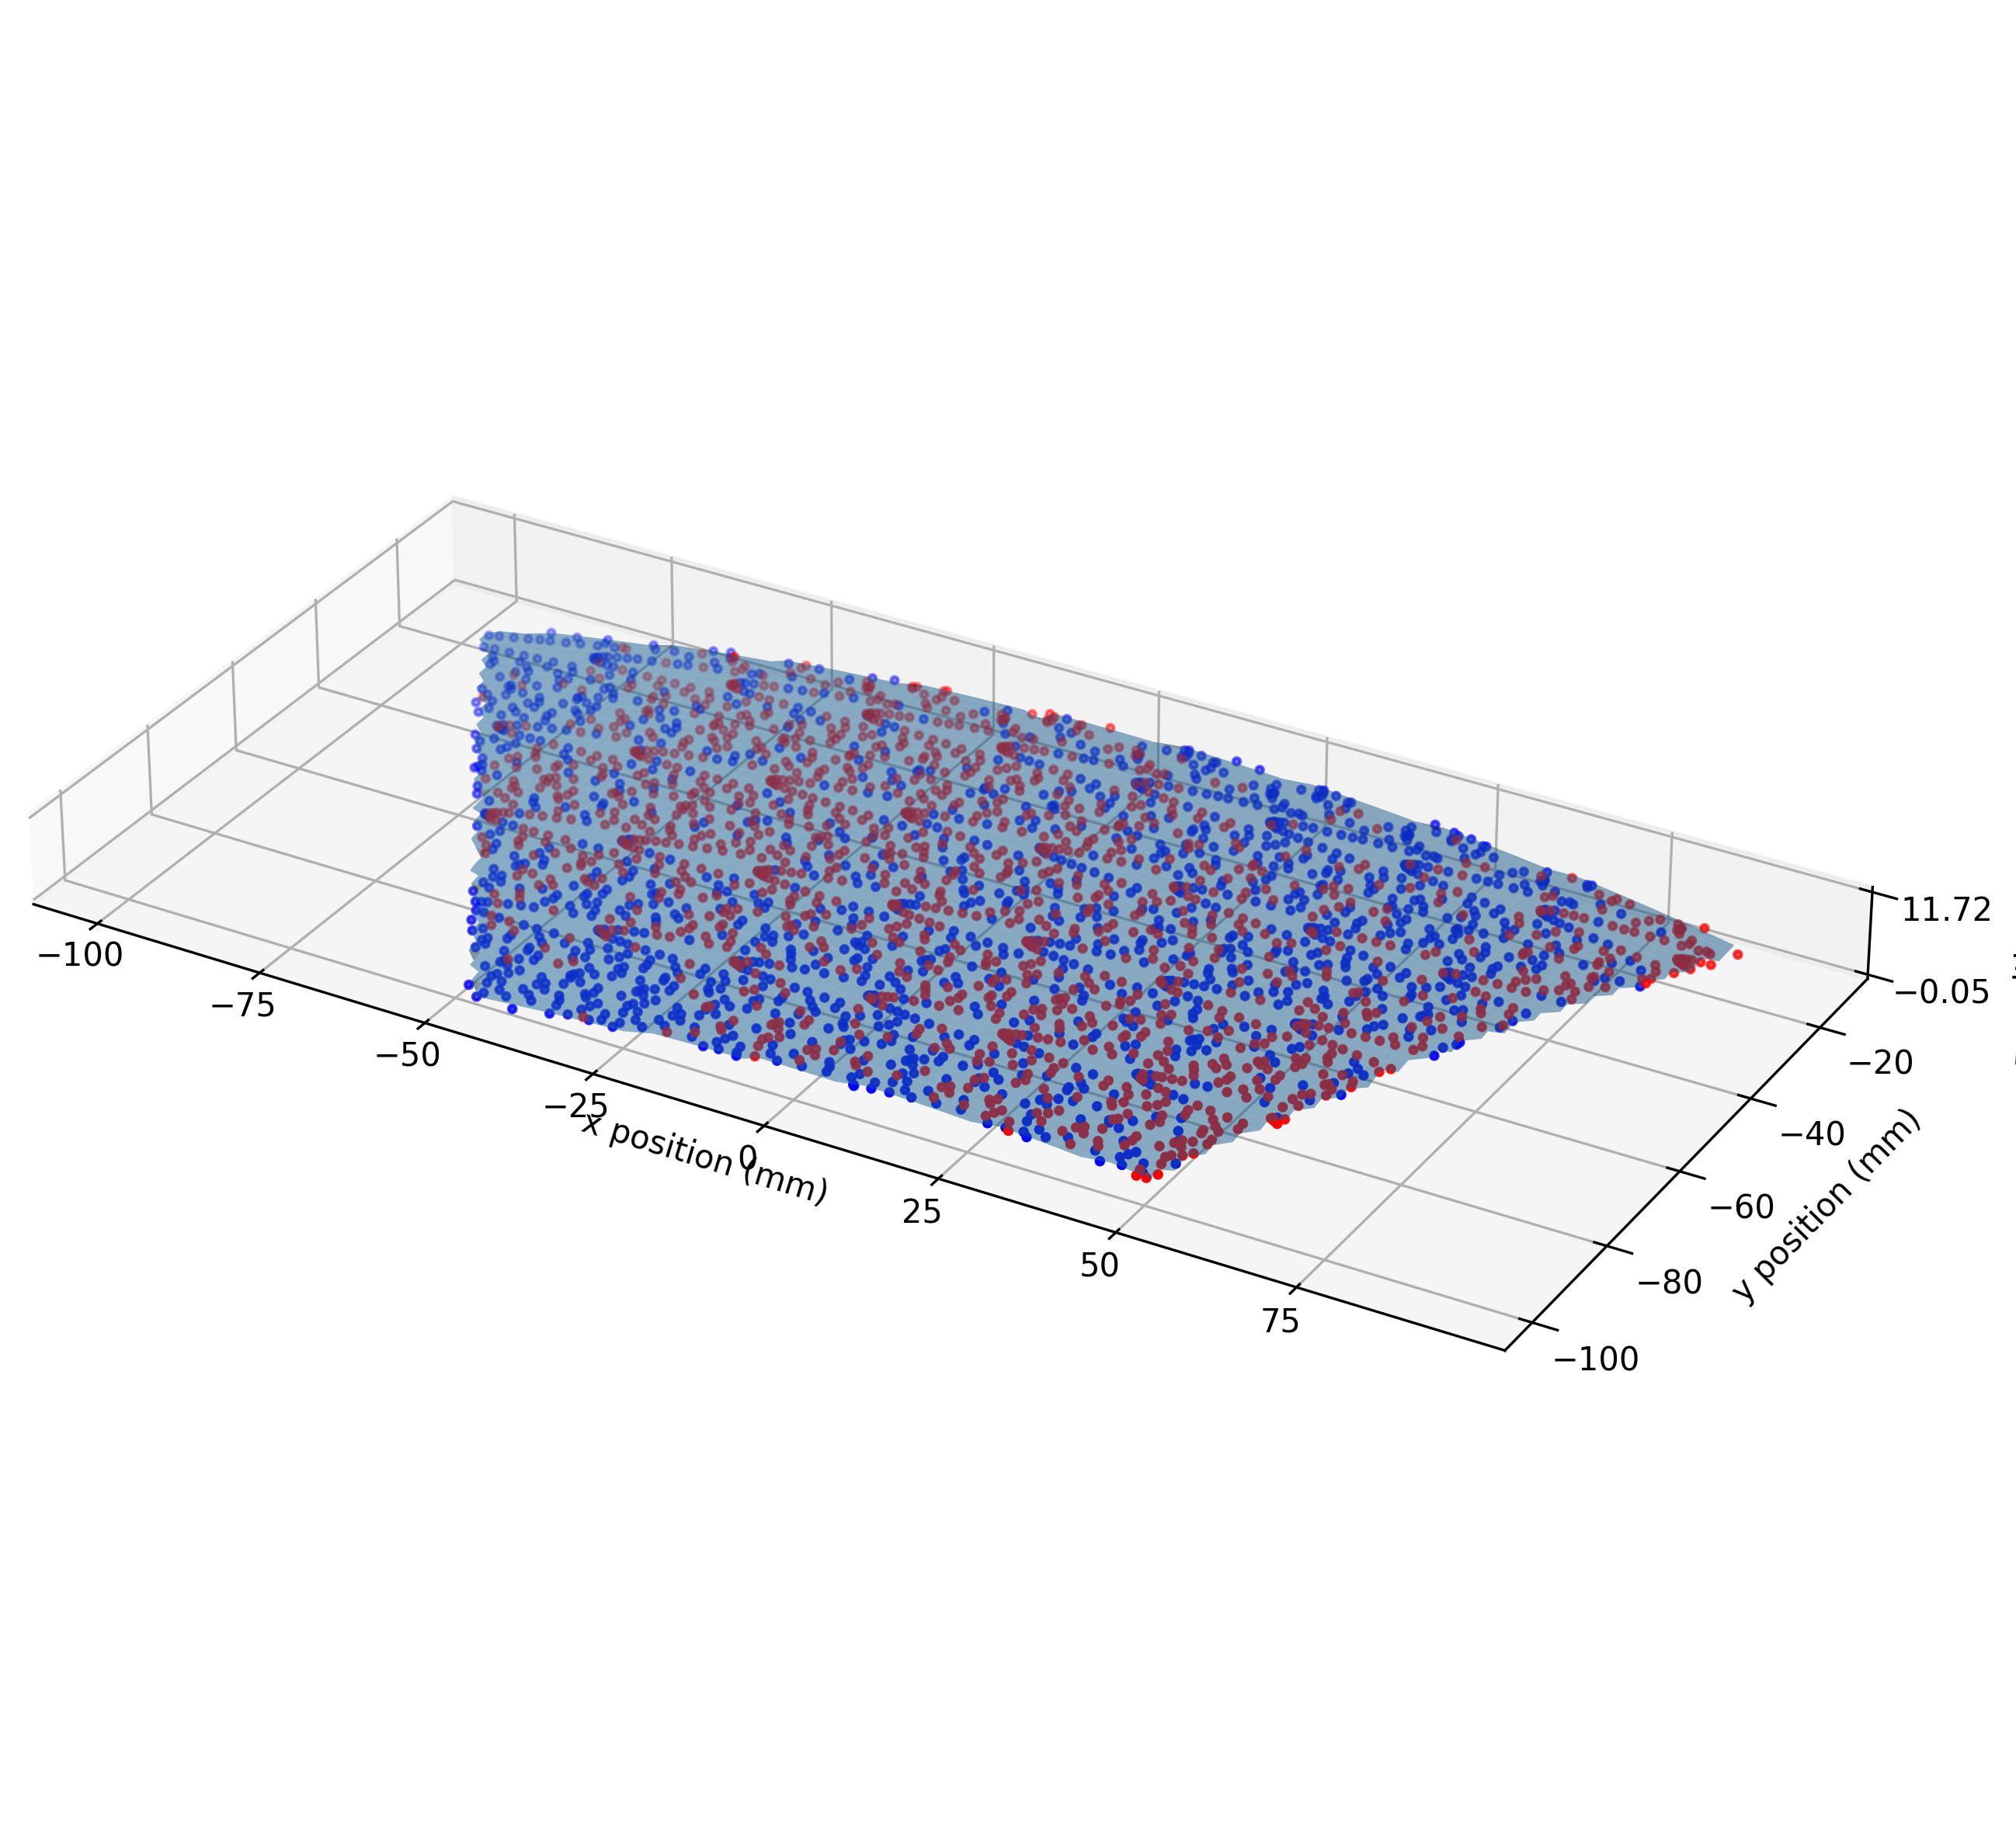

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
desample_step = 100
fig = plt.figure(figsize=(10,10), dpi=300)
ax = fig.add_subplot(111, projection='3d')

# ax.plot_trisurf(X, Y, Z, alpha=0.5, cmap='viridis')
x = np.linspace(data[:,0].min(), data[:,0].max(),100)
y = np.linspace(data[:,1].min(), data[:,1].max(),100)
X, Y = np.meshgrid(x, y, indexing = 'ij')
zi = griddata((data[:,0], data[:,1]), func(data[:,:], *popt),  (x[None,:], y[:,None]), method='linear')
difference = data[::desample_step,2] - func(data[::desample_step,:], *popt) > 0
ax.scatter(data[::desample_step,0][difference], data[::desample_step,1][difference],
           data[::desample_step,2][difference], c='b', marker='.')
ax.scatter(data[::desample_step,0][~difference], data[::desample_step,1][~difference],
           data[::desample_step,2][~difference], c='r', marker='.')
ax.plot_surface(X.T, Y.T, zi, alpha = 0.5)
ax.set_xlabel('x position (mm)')
ax.set_ylabel('y position (mm)')
ax.set_zlabel('z position (mm)')

ax.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(data[:,2])])

ax.set_zticks([data[:,2].min(), data[:,2].max()])

plt.show()


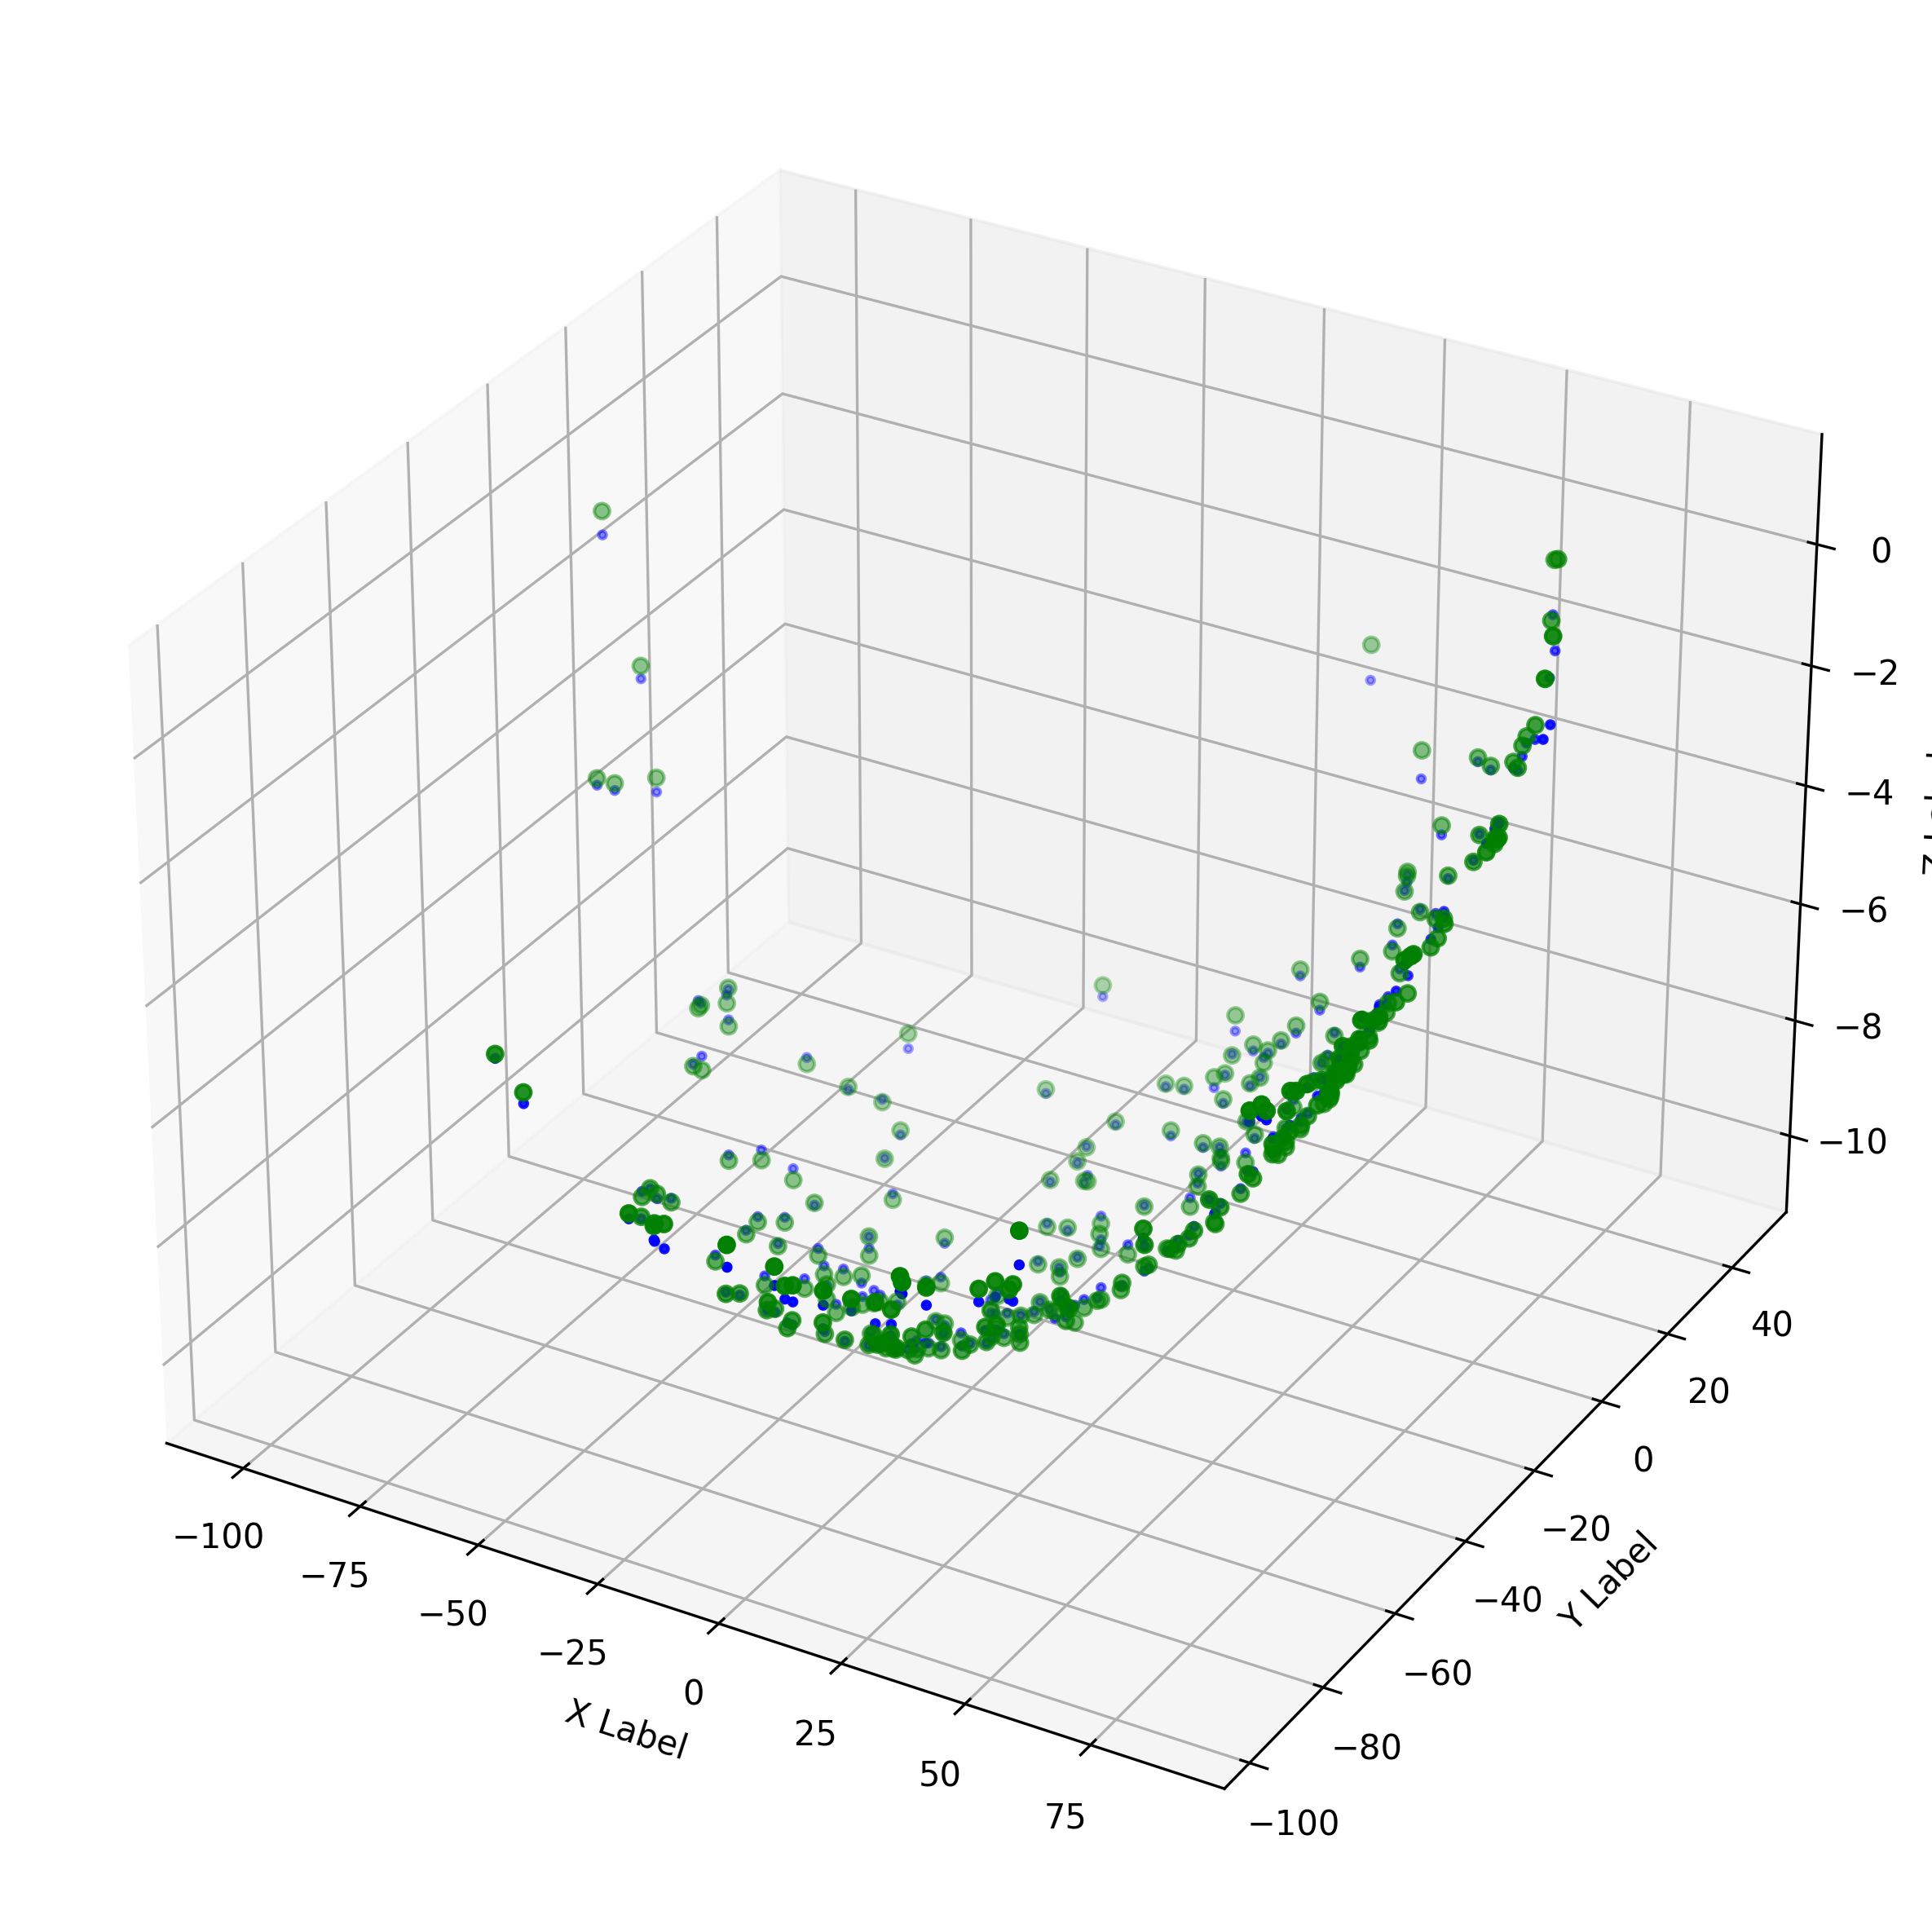

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

desample_step = 500
fig = plt.figure(figsize=(10,10), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[::desample_step,0], data[::desample_step,1], data[::desample_step,2], c='g', marker='o')
ax.scatter(data[::desample_step,0], data[::desample_step,1], func(data[::desample_step,:], *popt), c='b', marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()


In [19]:
RMSE = np.sqrt(np.mean((data[:,2]-func(data, *popt))**2))
print(f"RMSE:{RMSE}")



RMSE:0.04472593560026616


In [20]:
# 2D plot for the residual, color coded
# interpolate the data
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# define grid.
xi = np.linspace(np.min(data[:,0]),np.max(data[:,0]),1000)
yi = np.linspace(np.min(data[:,1]),np.max(data[:,1]),1000)
# grid the data
zi = griddata((data[:,0], data[:,1]), np.sqrt((data[:,2]-func(data[:,:], *popt))**2), (xi[None,:], yi[:,None]), method='linear')



<function matplotlib.pyplot.show(close=None, block=None)>

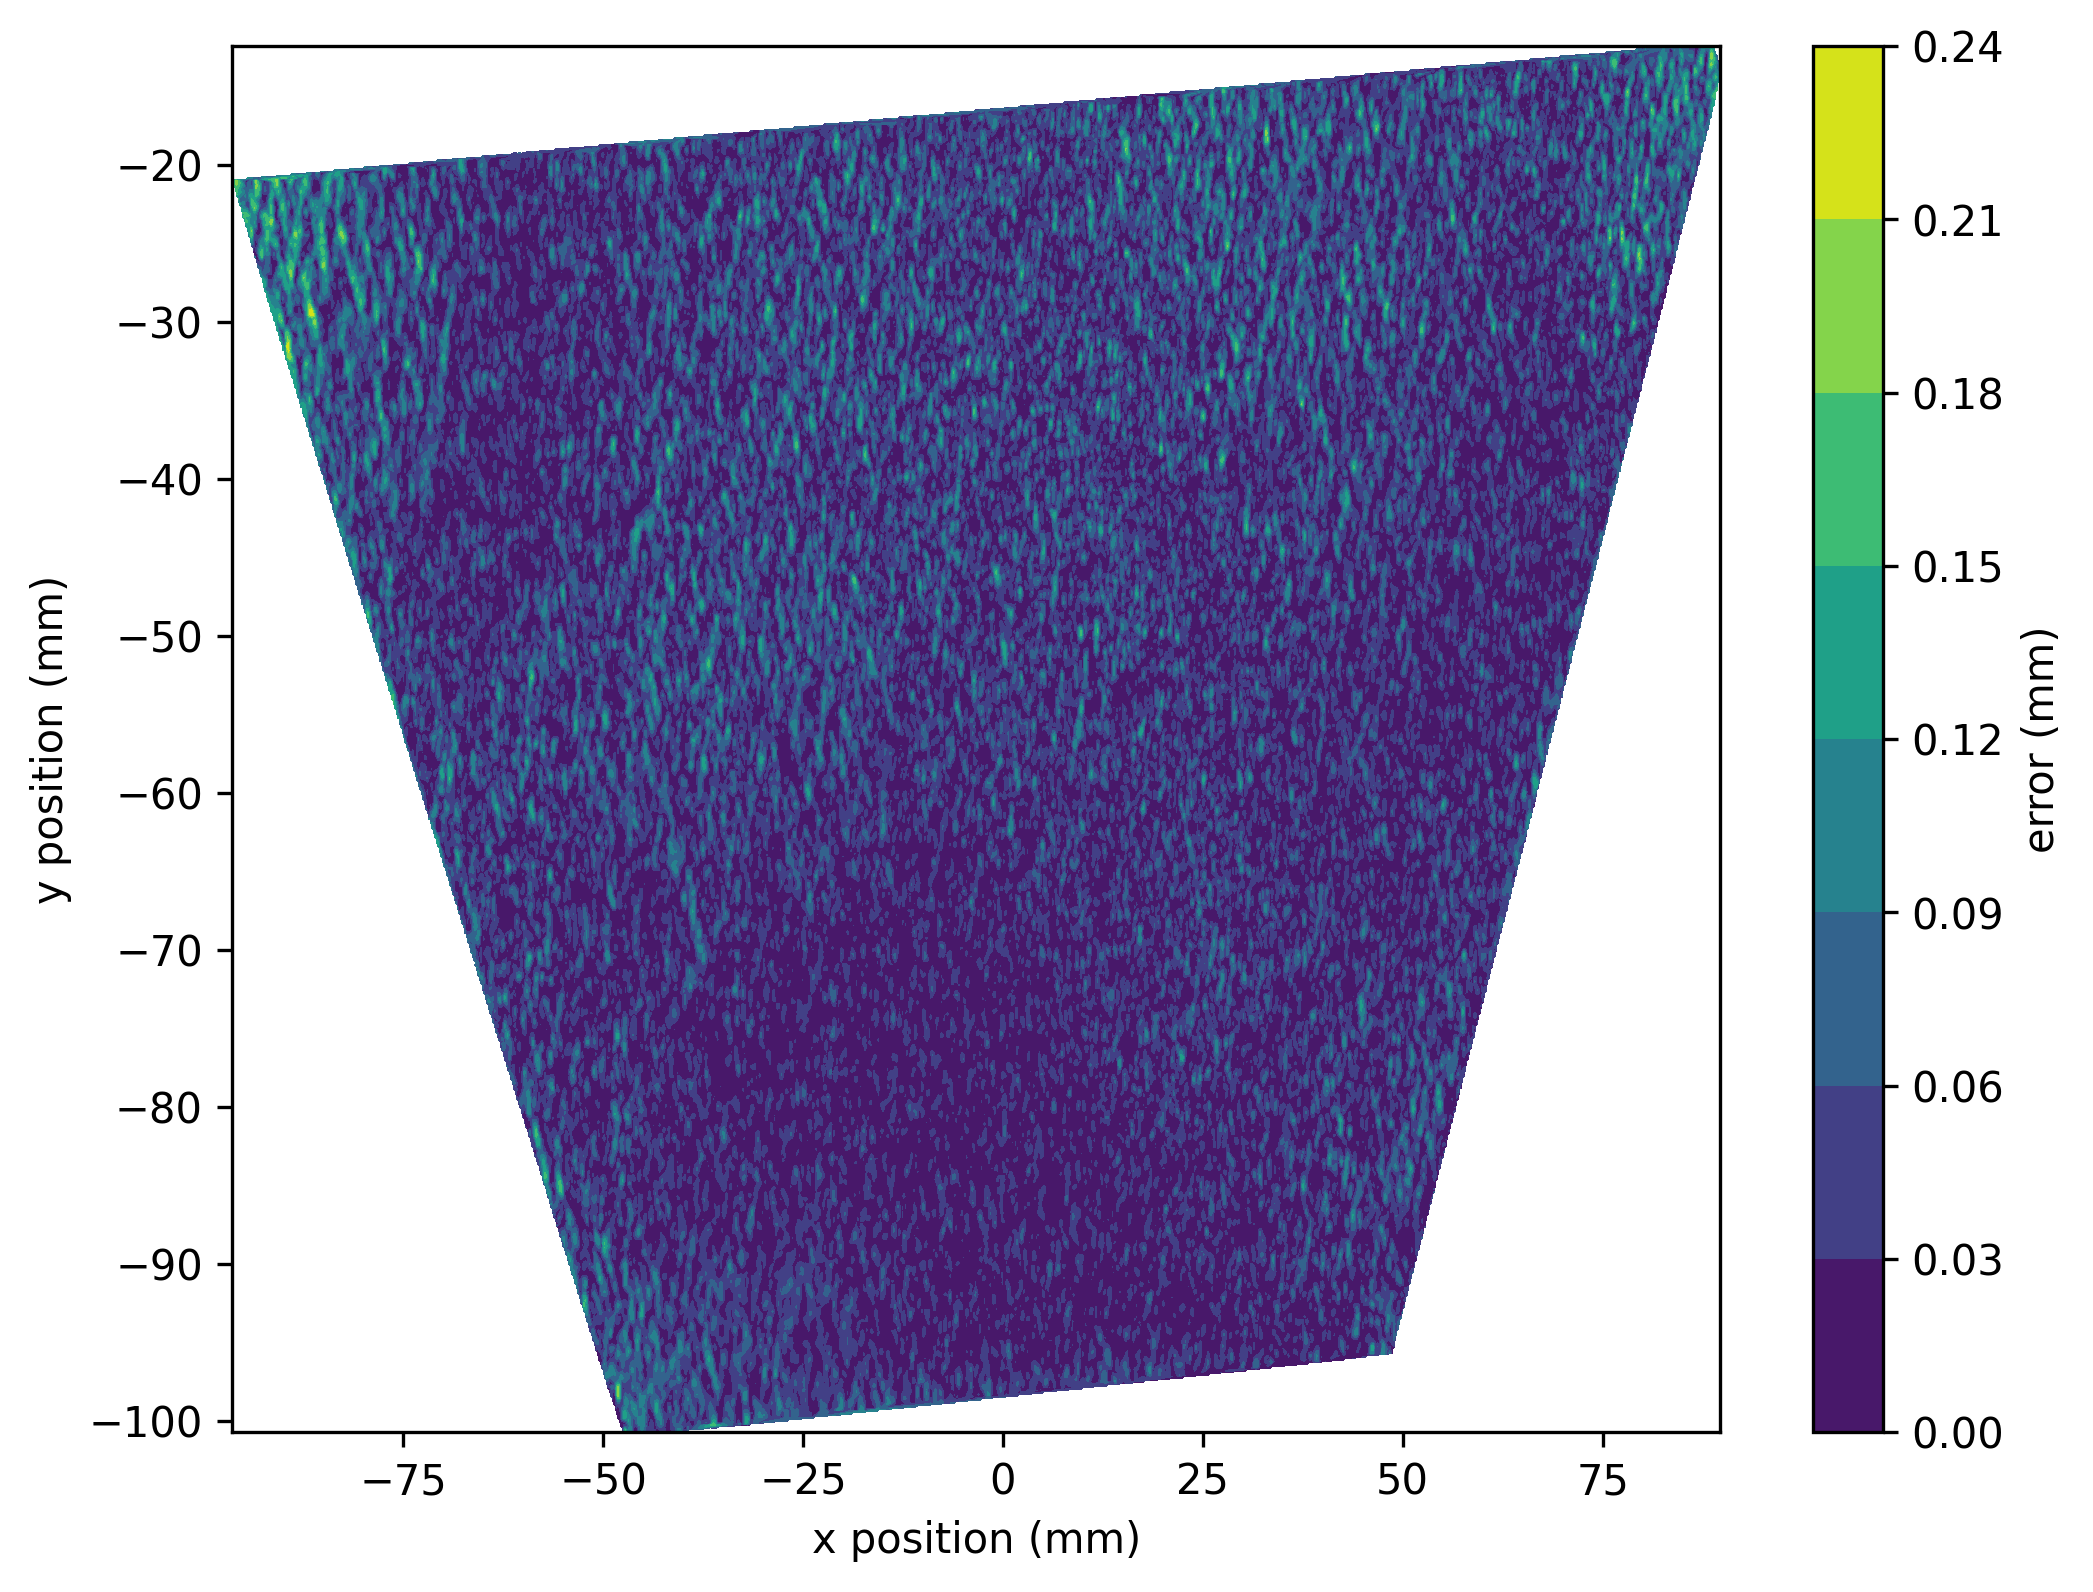

In [21]:
plt.figure(figsize=(8,6), dpi=300)
# contour the gridded data, plotting dots at the nonuniform data points.
#CS = plt.contourf(xi,yi,zi,10,vmin=-0.8, vmax= 0.5, cmap=plt.cm.jet,extend='neither')
CS = plt.contourf(xi,yi,zi)
# add colorbar title
cbar = plt.colorbar()
cbar.ax.set_ylabel('error (mm)')
# cbar.set_ticks([-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5])
# cbar.set_ticks(-1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5)

plt.xlim(np.min(data[:,0]), np.max(data[:,0]))
plt.ylim(np.min(data[:,1]), np.max(data[:,1]))
plt.xlabel('x position (mm)')
plt.ylabel('y position (mm)')
plt.show

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Unmount Drive
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
import numpy as np
x_values = data[:,0]
y_values = data[:,1]
z_values = data[:,2]
xy_values = np.column_stack((x_values,y_values))
#z_values = func(xy_values,*popt)
#print(f"{z_values}")
#print(f"{x_values}")
print(f"{P}")


NameError: ignored

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


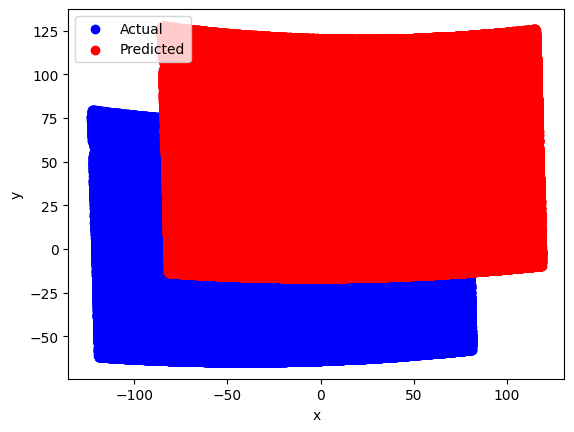

In [ ]:

predicted_z = func(data, *popt)
predicted_x = data[:, 0] + popt[3]
predicted_y = data[:, 1] + popt[4]
x_error = data[:,0] - predicted_x
y_error = data[:,1] - predicted_y

from sklearn.metrics import mean_squared_error
rmse_xy = np.sqrt(mean_squared_error(data[:, :2], np.column_stack((predicted_x, predicted_y))))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], c='b', label='Actual')
ax.scatter(predicted_x, predicted_y, c='r', label='Predicted')
#ax.scatter(x_error, y_error, c='g', label='Error')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [ ]:
import numpy as np
from numpy.linalg import lstsq
import pandas as pd

# Load the 3D point cloud data from the CSV file
# data = pd.read_csv('point_cloud_data.csv')
data = pd.read_csv('/content/drive/MyDrive/OpScan/NewHex01Foam02.csv', delimiter=',')
# data = data[1:,:] # remove the first row

x = data['x'].values
y = data['y'].values
z = data['z'].values

# Define the equation form for a parabolic surface: z = ax^2 + by^2 + cx + dy + e
A = np.column_stack((x**2, y**2, x, y, np.ones_like(x)))
b = z

# Solve the least-squares problem to obtain the coefficients
coefficients, residuals, _, _ = lstsq(A, b)

# Extract the coefficients for the equation
a, b, c, d, e = coefficients

# Display the equation of the parabolic surface
print(f"Equation of the parabolic surface: z = {a:.4f}x^2 + {b:.4f}y^2 + {c:.4f}x + {d:.4f}y + {e:.4f}")

Equation of the parabolic surface: z = -0.0010x^2 + -0.0010y^2 + -0.0011x + 0.0003y + -4.9068


<ipython-input-127-c34031d145d1>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficients, residuals, _, _ = lstsq(A, b)
